In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import time
import argparse
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
args = argparse.Namespace(name = "ConvMixer", 
                          batch_size = 512,
                          scale = 0.75,
                          reprob = 0.25,
                          ra_m = 8,
                          ra_n = 1,
                          jitter = 0.2,
                          hdim = 256,
                          depth = 8,
                          psize = 2,
                          conv_ks = 5,
                          wd = 0.005,
                          clip_norm = 'store_true',
                          epochs = 100,
                          lr_max = 0.05,
                          workers = 2,
                          cutmix_prob = 0.5, 
                          beta = 1.0 )

In [ ]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x

In [ ]:
def ConvMixer(dim, depth, kernel_size=5, patch_size=2, n_classes=10):
    return nn.Sequential(
        nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size),
        nn.GELU(),
        nn.BatchNorm2d(dim),
        *[nn.Sequential(
                Residual(nn.Sequential(
                    nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"),
                    nn.GELU(),
                    nn.BatchNorm2d(dim)
                )),
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim)
        ) for i in range(depth)],
        nn.AdaptiveAvgPool2d((1,1)),
        nn.Flatten(),
        nn.Linear(dim, n_classes)
    )

In [ ]:
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2471, 0.2435, 0.2616)

In [ ]:
# augmentation 포함된 변환
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(args.scale, 1.0), ratio=(1.0, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandAugment(num_ops=args.ra_n, magnitude=args.ra_m),
    transforms.ColorJitter(args.jitter, args.jitter, args.jitter),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
    transforms.RandomErasing(p=args.reprob)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

In [ ]:
# no augmentation
train_transform = transforms.Compose([
    #transforms.RandomResizedCrop(32, scale=(args.scale, 1.0), ratio=(1.0, 1.0)),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandAugment(num_ops=args.ra_n, magnitude=args.ra_m),
    #transforms.ColorJitter(args.jitter, args.jitter, args.jitter),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
    #transforms.RandomErasing(p=args.reprob)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size,
                                          shuffle=True, num_workers=args.workers)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                         shuffle=False, num_workers=args.workers)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
model = ConvMixer(args.hdim, args.depth, patch_size=args.psize, kernel_size=args.conv_ks, n_classes=10)
model = nn.DataParallel(model).cuda()

In [ ]:
lr_schedule = lambda t: np.interp([t], [0, args.epochs*2//5, args.epochs*4//5, args.epochs], 
                                  [0, args.lr_max, args.lr_max/20.0, 0])[0]

opt = optim.AdamW(model.parameters(), lr=args.lr_max, weight_decay=args.wd)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

In [ ]:
print(lr_schedule(10))

0.025


In [ ]:
train_loss_list = []
test_loss_list = []

train_acc_list = []
test_acc_list = []

lr_list = []
time_list = []

In [ ]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [ ]:
# train & test

for epoch in tqdm(range(args.epochs)):
    start = time.time()
    train_loss, train_acc, n = 0, 0, 0
    test_loss = 0 ##################################

    for i, (X, y) in enumerate(trainloader):
        model.train()
        X, y = X.cuda(), y.cuda()

        lr = lr_schedule(epoch + (i + 1)/len(trainloader))
        opt.param_groups[0].update(lr=lr)








        opt.zero_grad()
        with torch.cuda.amp.autocast():
            r = np.random.rand(1)
            if r<args.cutmix_prob:
                lam = np.random.beta(args.beta, args.beta)
                rand_index = torch.randperm(X.size()[0]).cuda()
                target_a = y
                target_b = y[rand_index]
                bbx1, bby1, bbx2, bby2 = rand_bbox(X.size(), lam)
                X[:, :, bbx1:bbx2, bby1:bby2] = X[rand_index, :, bbx1:bbx2, bby1:bby2]
                lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (X.size()[-1] * X.size()[-2]))
                output = model(X)
                loss = criterion(output, target_a) * lam + criterion(output, target_b) * (1. - lam)            
            else:
                output = model(X)
                loss = criterion(output, y)

        scaler.scale(loss).backward()
        if args.clip_norm:
            scaler.unscale_(opt)
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(opt)
        scaler.update()
        
        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        n += y.size(0)


        
    model.eval()
    test_acc, m = 0, 0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):
            X, y = X.cuda(), y.cuda()
            with torch.cuda.amp.autocast():
                output = model(X)
                test_loss_tmp = criterion(output, y) ###################


            test_loss += test_loss_tmp.item() * y.size(0) ##############

            test_acc += (output.max(1)[1] == y).sum().item()
            m += y.size(0)


    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    train_acc_list.append(train_acc/n)    
    test_acc_list.append(test_acc/m)
    lr_list.append(lr)
    time_list.append(time.time() - start)

    print(f'[{args.name}] Epoch: {epoch} | Train Acc: {train_acc/n:.4f}, Test Acc: {test_acc/m:.4f}, Time: {time.time() - start:.1f}, lr: {lr:.6f}')

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release not

[ConvMixer] Epoch: 0 | Train Acc: 0.8814, Test Acc: 0.9189, Time: 20.6, lr: 0.001250


  2%|▏         | 2/100 [00:41<33:42, 20.64s/it]

[ConvMixer] Epoch: 1 | Train Acc: 0.9377, Test Acc: 0.9161, Time: 20.7, lr: 0.002500


  3%|▎         | 3/100 [01:02<33:30, 20.72s/it]

[ConvMixer] Epoch: 2 | Train Acc: 0.8770, Test Acc: 0.9162, Time: 20.8, lr: 0.003750


  4%|▍         | 4/100 [01:22<33:16, 20.80s/it]

[ConvMixer] Epoch: 3 | Train Acc: 0.8803, Test Acc: 0.9138, Time: 20.9, lr: 0.005000


  5%|▌         | 5/100 [01:44<33:03, 20.88s/it]

[ConvMixer] Epoch: 4 | Train Acc: 0.8525, Test Acc: 0.9111, Time: 21.0, lr: 0.006250


  6%|▌         | 6/100 [02:05<32:51, 20.97s/it]

[ConvMixer] Epoch: 5 | Train Acc: 0.8784, Test Acc: 0.9051, Time: 21.1, lr: 0.007500


  7%|▋         | 7/100 [02:26<32:39, 21.07s/it]

[ConvMixer] Epoch: 6 | Train Acc: 0.8816, Test Acc: 0.9053, Time: 21.3, lr: 0.008750


  8%|▊         | 8/100 [02:47<32:26, 21.15s/it]

[ConvMixer] Epoch: 7 | Train Acc: 0.8720, Test Acc: 0.9051, Time: 21.3, lr: 0.010000


  8%|▊         | 8/100 [02:59<34:23, 22.43s/it]


KeyboardInterrupt: ignored

In [ ]:
print(train_loss_list)
print(test_loss_list)

print(train_acc_list)
print(test_acc_list)
print(lr_list)
print(time_list)

[87274.24717521667, 70427.10583686829, 57847.91020774841, 52248.85096740723, 43923.69031524658, 48939.102880477905, 45604.10953044891, 42197.50939941406, 43673.94547653198, 43743.34078025818, 39945.05134963989, 42043.527691841125, 37468.75533723831, 39735.946846961975, 40693.92558670044, 34067.65771651268, 35798.83839607239, 40563.276683330536, 29797.660234451294, 32320.179008483887, 36132.5338435173, 35936.041783332825, 35515.03500747681, 35106.44253540039, 36462.08275079727, 36550.909786224365, 33734.538846969604, 36038.025488615036, 34942.305377960205, 34498.652070999146, 35314.694118499756, 37061.637996673584, 28444.828571558, 32298.64860010147, 36236.49448776245, 32826.8868227005, 32929.8063583374, 38410.58723449707, 31316.809926986694, 30510.519355773926, 38088.94952964783, 27836.098707437515, 32401.825891017914, 30696.744955062866, 31692.775124549866, 29815.939394831657, 25774.03298187256, 31727.11532020569, 26472.847053527832, 28079.135968208313, 27249.929523468018, 28034.42979

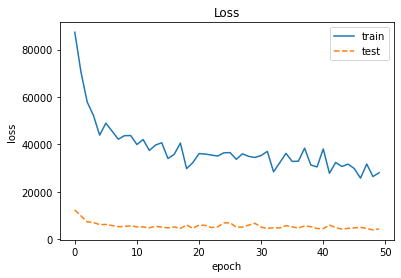

In [ ]:
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(train_loss_list[:50], '-', label = "train")
plt.plot(test_loss_list[:50], '--', label = "test")
plt.legend()
plt.savefig('loss.png', dpi=300)

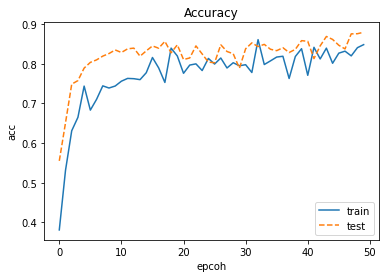

In [ ]:
plt.title("Accuracy")
plt.xlabel("epcoh")
plt.ylabel("acc")
plt.plot(train_acc_list[:50], "-", label = "train")
plt.plot(test_acc_list[:50], "--", label = "test")
plt.legend()
plt.savefig('accuracy.png', dpi=300)

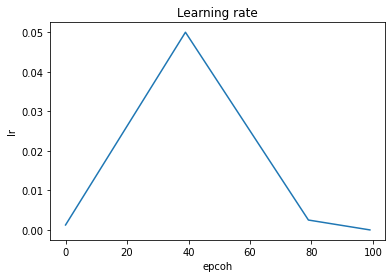

In [ ]:
plt.title("Learning rate")
plt.xlabel("epcoh")
plt.ylabel("lr")
plt.plot(lr_list)
plt.savefig('learningrate.png', dpi=300)

In [ ]:
sum(time_list) / len(time_list)

21.991082777976988

(50000, 10000)